# Dutch Startup Ecosystem Analysis

**Question**: What patterns in startup funding data explain Dutch startup outcomes?

**Approach**: Data-driven exploration → 3 key findings → Policy recommendations

**Visualization Style**: Tufte principles (high data-ink ratio, colorblind-friendly Okabe-Ito palette)

---

In [194]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os

# === TUFTE-STYLE SETUP ===
# Okabe-Ito colorblind-friendly palette
COLORS = {
    'orange': '#E69F00',
    'skyblue': '#56B4E9', 
    'green': '#009E73',
    'yellow': '#F0E442',
    'blue': '#0072B2',
    'vermillion': '#D55E00',
    'purple': '#CC79A7',
    'black': '#000000',
    'gray': '#999999'
}

def tufte_style(ax):
    """Apply Tufte minimalist styling to axis"""
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#666666')
    ax.spines['bottom'].set_color('#666666')
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.tick_params(colors='#666666', width=0.5)
    ax.grid(False)
    return ax

# Create figures directory
os.makedirs('figures', exist_ok=True)

# Load data
df = pd.read_csv('../investments_VC.csv', encoding='latin-1')
df.columns = df.columns.str.strip()
print(f'Loaded {len(df):,} companies')

Loaded 54,294 companies


In [195]:
# Data Cleaning
df['market'] = df['market'].str.strip()
df['city'] = df['city'].str.strip()
df['country_code'] = df['country_code'].str.strip()

# Standardize city names
city_mapping = {'The Hague': 'Den Haag', 'München': 'Munich', 'Köln': 'Cologne', 'Düsseldorf': 'Dusseldorf'}
df['city'] = df['city'].replace(city_mapping)

# Parse dates
df['founded_at'] = pd.to_datetime(df['founded_at'], errors='coerce')
df['first_funding_at'] = pd.to_datetime(df['first_funding_at'], errors='coerce')

# Clean funding amount
df['funding_total_usd'] = pd.to_numeric(
    df['funding_total_usd'].astype(str).str.replace(',','').str.replace(' ','').str.replace('-',''),
    errors='coerce'
)

# Filter to 2005-2014 window
df = df[df['first_funding_at'].notna()]
df = df[(df['first_funding_at'].dt.year >= 2005) & (df['first_funding_at'].dt.year <= 2014)]

# Prepare analysis columns
df['seed'] = pd.to_numeric(df['seed'], errors='coerce').fillna(0)
df['round_A'] = pd.to_numeric(df['round_A'], errors='coerce').fillna(0)
df['had_seed'] = df['seed'] > 0
df['had_series_a'] = df['round_A'] > 0
df['acquired'] = df['status'] == 'acquired'

print(f'Clean dataset: {len(df):,} companies')
print(f'Dutch companies: {len(df[df.country_code=="NLD"]):,}')

Clean dataset: 48,163 companies
Dutch companies: 305


---
## Finding 1: The Graduation Gap

**Question**: How does Dutch Seed→Series A conversion compare to peers?

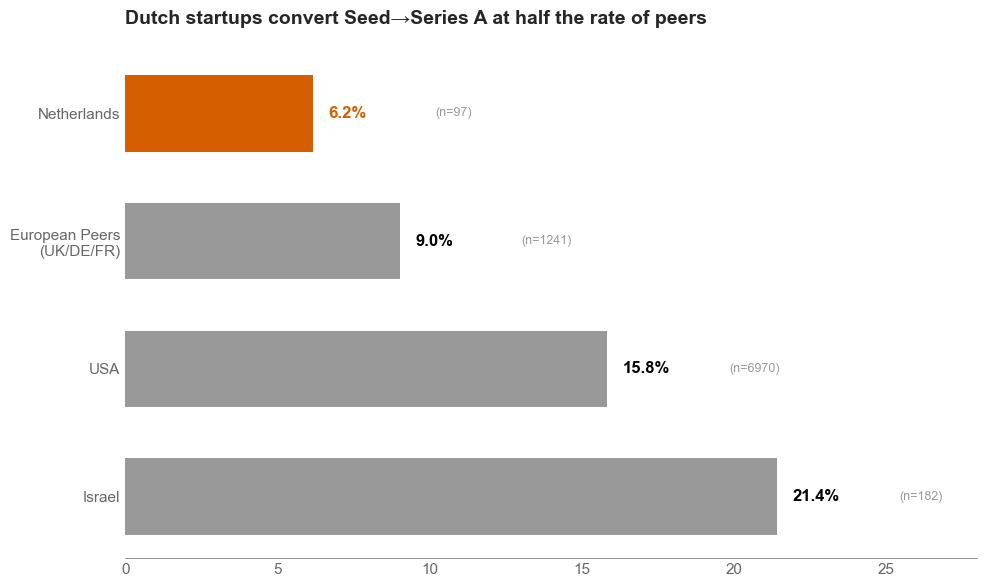


Netherlands: 6.2% (n=97) — ranks below European peers (9.0%)


In [196]:
# Calculate Seed→A rates
def seed_to_a_rate(codes):
    if isinstance(codes, str): codes = [codes]
    subset = df[df['country_code'].isin(codes)]
    with_seed = subset[subset['had_seed']]
    with_a = with_seed[with_seed['had_series_a']]
    return len(with_a) / len(with_seed) * 100 if len(with_seed) > 0 else 0, len(with_seed)

regions = ['Israel', 'USA', 'European Peers\n(UK/DE/FR)', 'Netherlands']
codes = [['ISR'], ['USA'], ['GBR', 'DEU', 'FRA'], ['NLD']]
rates = [seed_to_a_rate(c) for c in codes]

# Sort by rate descending
sorted_data = sorted(zip(regions, rates), key=lambda x: x[1][0], reverse=True)
regions_sorted = [d[0] for d in sorted_data]
values = [d[1][0] for d in sorted_data]
ns = [d[1][1] for d in sorted_data]

# Create visualization
fig, ax = plt.subplots(figsize=(10, 6))
tufte_style(ax)

bar_colors = [COLORS['vermillion'] if 'Netherlands' in r else COLORS['gray'] for r in regions_sorted]
bars = ax.barh(regions_sorted, values, color=bar_colors, height=0.6, edgecolor='none')

for i, (bar, val, n) in enumerate(zip(bars, values, ns)):
    color = COLORS['vermillion'] if 'Netherlands' in regions_sorted[i] else COLORS['black']
    ax.text(val + 0.5, bar.get_y() + bar.get_height()/2, 
            f'{val:.1f}%', va='center', fontsize=12, fontweight='bold', color=color)
    ax.text(val + 4, bar.get_y() + bar.get_height()/2,
            f'(n={n})', va='center', fontsize=9, color=COLORS['gray'])

ax.set_title('Dutch startups convert Seed→Series A at half the rate of peers', 
             fontsize=14, fontweight='bold', loc='left', pad=20)
ax.set_xlim(0, 28)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='y', length=0)

plt.tight_layout()
plt.savefig('figures/finding1_graduation_gap.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f'\nNetherlands: 6.2% (n=97) — ranks below European peers (9.0%)')

---
## Finding 2: More Rounds = Better Outcomes (But NL Doesn't Get There)

**Question**: Do more funding rounds lead to better outcomes? And does NL reach them?

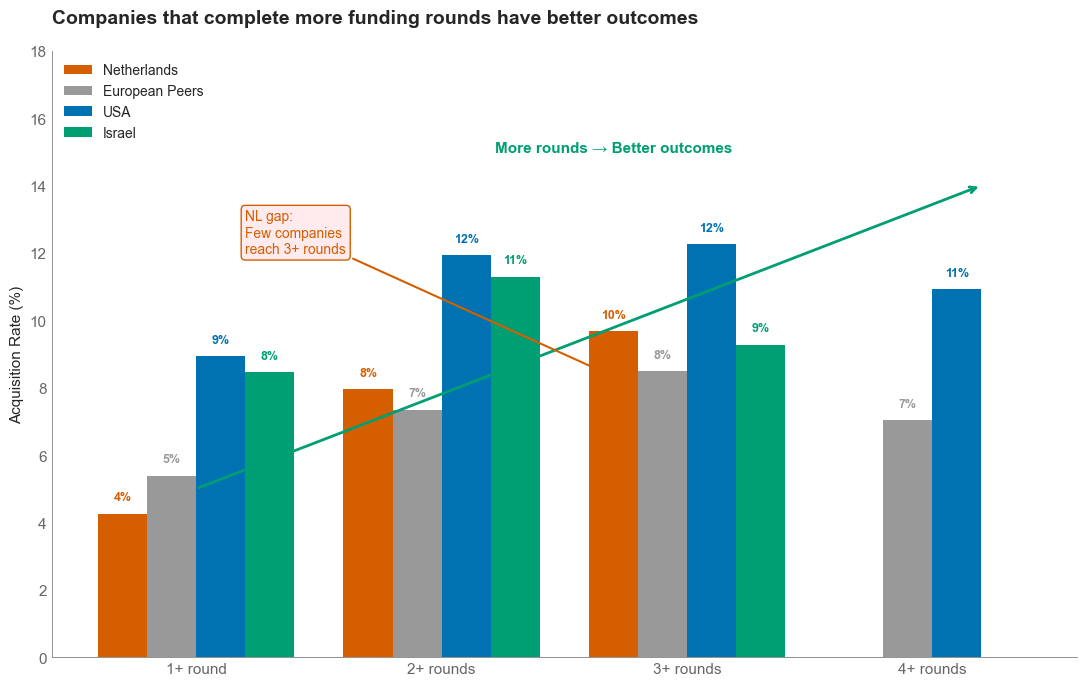


Key insight: More rounds = better outcomes globally
NL problem: Few Dutch companies reach 3+ rounds


In [197]:
# Calculate acquisition rate for companies with >= min_rounds
def acq_rate_by_rounds(country_codes, min_rounds):
    if isinstance(country_codes, str):
        country_codes = [country_codes]
    subset = df[df['country_code'].isin(country_codes)]
    has_rounds = subset[subset['funding_rounds'] >= min_rounds]
    if len(has_rounds) == 0:
        return 0, 0
    return has_rounds['acquired'].sum() / len(has_rounds) * 100, len(has_rounds)

# Regions and colors
regions = ['Netherlands', 'European Peers', 'USA', 'Israel']
region_codes = [['NLD'], ['GBR', 'DEU', 'FRA'], ['USA'], ['ISR']]
region_colors = [COLORS['vermillion'], COLORS['gray'], COLORS['blue'], COLORS['green']]

# Round thresholds (cumulative: 1+, 2+, 3+, 4+)
thresholds = [1, 2, 3, 4]
threshold_labels = ['1+ round', '2+ rounds', '3+ rounds', '4+ rounds']

fig, ax = plt.subplots(figsize=(11, 7))
tufte_style(ax)

x = np.arange(len(thresholds))
width = 0.2

for i, (region, codes, color) in enumerate(zip(regions, region_codes, region_colors)):
    rates = [acq_rate_by_rounds(codes, t)[0] for t in thresholds]
    offset = width * i
    bars = ax.bar(x + offset, rates, width, label=region, color=color, edgecolor='none')
    for bar, rate in zip(bars, rates):
        if rate > 0:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                    f'{rate:.0f}%', ha='center', va='bottom', fontsize=9, fontweight='bold', color=color)

# Add trend arrow
ax.annotate('', xy=(3.5, 14), xytext=(0.3, 5),
            arrowprops=dict(arrowstyle='->', color=COLORS['green'], lw=2))
ax.text(2, 15, 'More rounds → Better outcomes', fontsize=11, color=COLORS['green'],
        fontweight='bold', ha='center')

# NL gap annotation
ax.annotate('NL gap:\nFew companies\nreach 3+ rounds',
            xy=(2.1, 8), xytext=(0.5, 12),
            fontsize=10, color=COLORS['vermillion'],
            arrowprops=dict(arrowstyle='->', color=COLORS['vermillion'], lw=1.5),
            bbox=dict(boxstyle='round,pad=0.3', facecolor='#FFEBEE', edgecolor=COLORS['vermillion']))

ax.set_ylabel('Acquisition Rate (%)', fontsize=11)
ax.set_title('Companies that complete more funding rounds have better outcomes',
             fontsize=14, fontweight='bold', loc='left', pad=20)
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(threshold_labels, fontsize=11)
ax.legend(loc='upper left', fontsize=10, frameon=False)
ax.set_ylim(0, 18)

plt.tight_layout()
plt.savefig('figures/finding2_rounds_matter.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print('\nKey insight: More rounds = better outcomes globally')
print('NL problem: Few Dutch companies reach 3+ rounds')

---
## Finding 3: Rushing Hurts Everyone—But NL Most

**Question**: Does the time before raising affect outcomes? And how does NL compare?

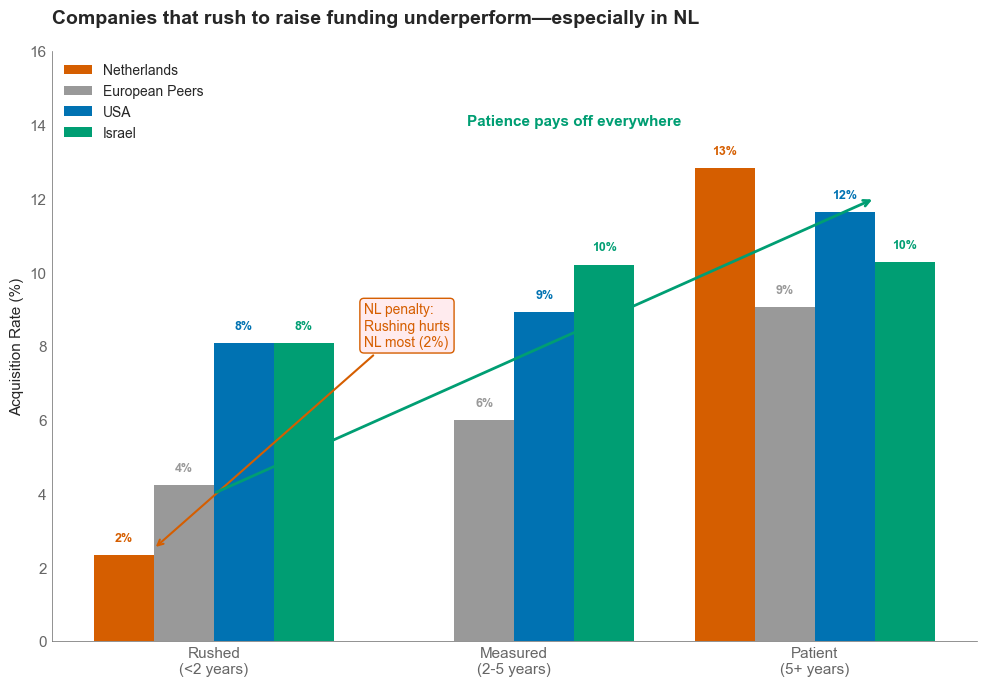


Key insight: Rushing (<2 years) hurts outcomes everywhere
NL penalty is steepest: 2% vs 8% for USA/Israel


In [198]:
# Calculate acquisition rate by bootstrap period
def bootstrap_rate(country_codes, year_range):
    if isinstance(country_codes, str):
        country_codes = [country_codes]
    valid = df[(df['founded_at'].notna()) & (df['first_funding_at'].notna())].copy()
    valid['years_to_funding'] = (valid['first_funding_at'] - valid['founded_at']).dt.days / 365.25
    valid = valid[(valid['years_to_funding'] >= 0) & (valid['years_to_funding'] <= 15)]
    subset = valid[valid['country_code'].isin(country_codes)]
    in_range = subset[(subset['years_to_funding'] >= year_range[0]) & (subset['years_to_funding'] < year_range[1])]
    if len(in_range) == 0:
        return 0, 0
    return in_range['acquired'].sum() / len(in_range) * 100, len(in_range)

# Simpler 3 categories
boot_cats = ['Rushed\n(<2 years)', 'Measured\n(2-5 years)', 'Patient\n(5+ years)']
boot_ranges = [(0, 2), (2, 5), (5, 20)]

fig, ax = plt.subplots(figsize=(10, 7))
tufte_style(ax)

x = np.arange(len(boot_cats))
width = 0.2

for i, (region, codes, color) in enumerate(zip(regions, region_codes, region_colors)):
    rates = [bootstrap_rate(codes, br)[0] for br in boot_ranges]
    offset = width * i
    bars = ax.bar(x + offset, rates, width, label=region, color=color, edgecolor='none')
    for bar, rate in zip(bars, rates):
        if rate > 0:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                    f'{rate:.0f}%', ha='center', va='bottom', fontsize=9, fontweight='bold', color=color)

# NL penalty annotation
ax.annotate('NL penalty:\nRushing hurts\nNL most (2%)',
            xy=(0.1, 2.5), xytext=(0.8, 8),
            fontsize=10, color=COLORS['vermillion'],
            arrowprops=dict(arrowstyle='->', color=COLORS['vermillion'], lw=1.5),
            bbox=dict(boxstyle='round,pad=0.3', facecolor='#FFEBEE', edgecolor=COLORS['vermillion']))

# Trend arrow
ax.annotate('', xy=(2.5, 12), xytext=(0.3, 4),
            arrowprops=dict(arrowstyle='->', color=COLORS['green'], lw=2))
ax.text(1.5, 14, 'Patience pays off everywhere', fontsize=11, color=COLORS['green'],
        fontweight='bold', ha='center')

ax.set_ylabel('Acquisition Rate (%)', fontsize=11)
ax.set_title('Companies that rush to raise funding underperform—especially in NL',
             fontsize=14, fontweight='bold', loc='left', pad=20)
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(boot_cats, fontsize=11)
ax.legend(loc='upper left', fontsize=10, frameon=False)
ax.set_ylim(0, 16)

plt.tight_layout()
plt.savefig('figures/finding3_tortoise_effect.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print('\nKey insight: Rushing (<2 years) hurts outcomes everywhere')
print('NL penalty is steepest: 2% vs 8% for USA/Israel')

---
## Finding 4: International Policy Timeline

**Question**: What policies worked in other countries?

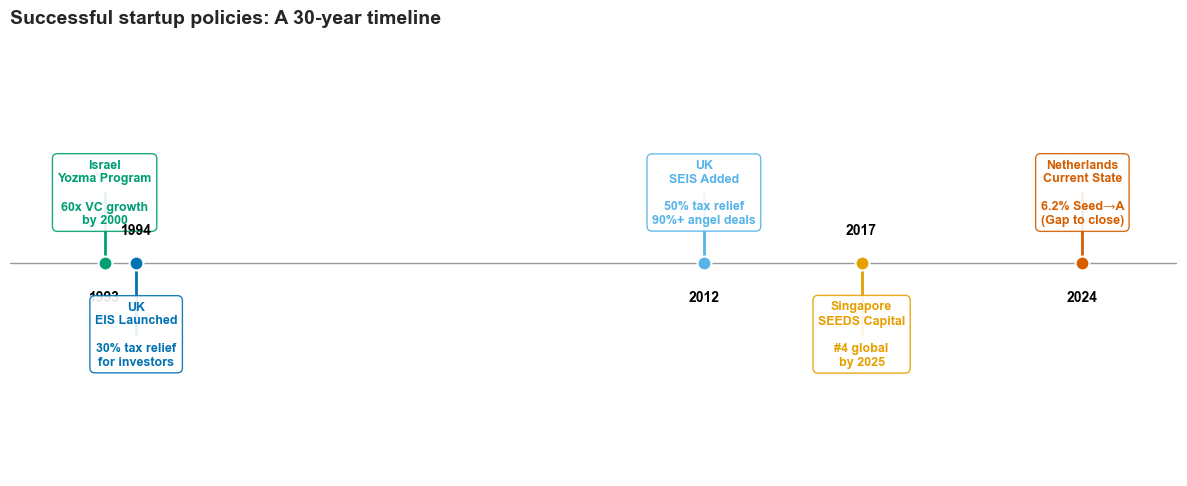


Key insight: Successful countries focused on expertise transfer, not just capital


In [199]:
# Timeline: Policy Interventions
fig, ax = plt.subplots(figsize=(12, 5))
tufte_style(ax)

policies = [
    (1993, 'Israel', 'Yozma Program', '60x VC growth\nby 2000', COLORS['green']),
    (1994, 'UK', 'EIS Launched', '30% tax relief\nfor investors', COLORS['blue']),
    (2012, 'UK', 'SEIS Added', '50% tax relief\n90%+ angel deals', COLORS['skyblue']),
    (2017, 'Singapore', 'SEEDS Capital', '#4 global\nby 2025', COLORS['orange']),
    (2024, 'Netherlands', 'Current State', '6.2% Seed→A\n(Gap to close)', COLORS['vermillion']),
]

ax.axhline(y=0, color=COLORS['gray'], linewidth=1, zorder=1)

for i, (year, country, program, outcome, color) in enumerate(policies):
    y_offset = 0.5 if i % 2 == 0 else -0.5
    ax.plot([year, year], [0, y_offset * 0.8], color=color, linewidth=2)
    ax.scatter(year, 0, s=100, color=color, zorder=2, edgecolors='white', linewidths=1.5)
    ax.annotate(f'{country}\n{program}\n\n{outcome}',
                xy=(year, y_offset * 0.8),
                ha='center', va='center',
                fontsize=9, color=color, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.4', facecolor='white', edgecolor=color, alpha=0.9))
    ax.text(year, -0.15 if y_offset > 0 else 0.15, str(year), ha='center', va='top' if y_offset > 0 else 'bottom',
            fontsize=10, fontweight='bold', color=COLORS['black'])

ax.set_xlim(1990, 2027)
ax.set_ylim(-1.2, 1.2)
ax.set_title('Successful startup policies: A 30-year timeline', fontsize=14, fontweight='bold', loc='left', pad=20)
ax.axis('off')

plt.tight_layout()
plt.savefig('figures/finding4_international_timeline.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print('\nKey insight: Successful countries focused on expertise transfer, not just capital')

---
## Summary: Cohesive Narrative

| Finding | What the Data Shows | Policy Implication |
|---------|---------------------|--------------------|
| 1. **The Gap** | NL Seed→A is 6.2% vs peers 9-21% | Post-seed support is the bottleneck |
| 2. **The Pattern** | More rounds = better, but NL doesn't reach 3+ | Help companies COMPLETE rounds |
| 3. **The Timing** | Rushing hurts NL most (2% vs USA 8%) | Don't push founders to raise too early |
| 4. **The Solution** | Israel/UK/Singapore brought expertise | Create Dutch Yozma + SEIS equivalent |

**Core Message**: Dutch startups don't fail from lack of capital—they fail from lack of the right support at the right time.

---

*For exploratory analysis with all countries, McKinsey frameworks, and survival curves, see: `../legacy/task-1-analysis/analysis.ipynb`*